# Cross-validation by functional group
This notebook computes the expected error after cross-validation by functional group, and creates Figure 2 in the manuscript. Cross-validating by functional group is how the model hyperparameters are found, and this step therefore confirms that we get reasonable performance from the model without training on explicitly similar molecules. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
from ysi_utils.models.setup_model import model

from ysi_utils.data import low
from ysi_utils.descriptors import dragon
from ysi_utils.validation import y_train as y
from ysi_utils.validation import y_test

X = dragon.loc[y.index]
X_test = dragon.loc[y_test.index]

Using Theano backend.


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_predict
from sklearn.metrics import median_absolute_error

/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


*Warning*, This next step takes a lot of computational effort.

In [ ]:
labels = LabelEncoder().fit_transform(low.set_index('SMILES').loc[X.index].Type)

y_cvlabel_predict = cross_val_predict(model, X.values, y.YSI.values,
                                      cv=LeaveOneLabelOut(labels))
# Save the results to a binary file
y_cvlabel_predict.tofile('y_cvlabel_predict.npy')

Or, load the data from a previous run

In [4]:
y_cvlabel_predict = np.fromfile('y_cvlabel_predict.npy')

In [5]:
y_cvlabel = pd.DataFrame(y).join(pd.Series(y_cvlabel_predict.flatten(), index=y.index, name='YSI_cv'))
y_cvlabel['YSI_diff'] = y_cvlabel.YSI_cv - y_cvlabel.YSI
medians = y_cvlabel.groupby('Type').median().YSI_diff
order = medians.index[medians.argsort()].tolist()[::-1]

median_absolute_error(y_cvlabel.YSI, y_cvlabel.YSI_cv)

7.0254009842872627

In [6]:
from ysi_utils.models import outlier_model
y_cvlabel['inlier'] = outlier_model.predict(X) == 1

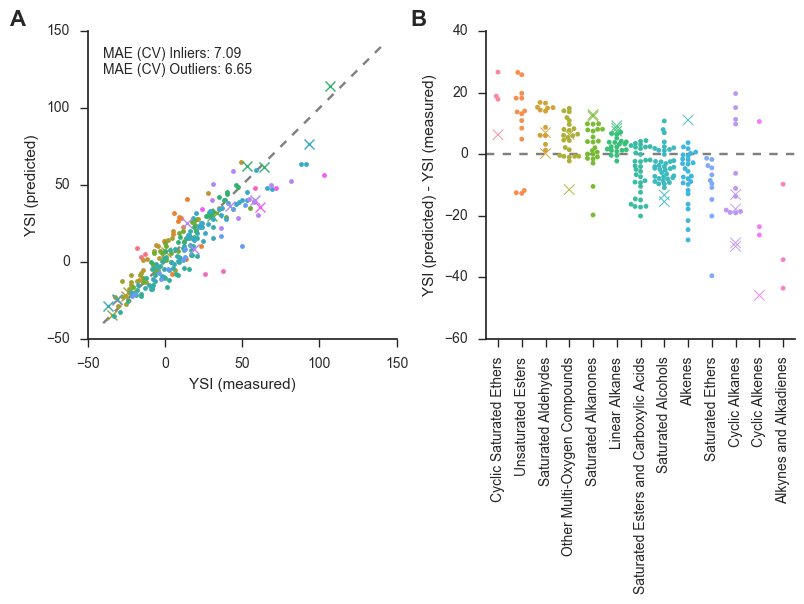

In [22]:
from swarmplot import myswarmplot

with sns.axes_style('ticks'):
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(121)
    
    for moltype, color in zip(order, sns.color_palette('husl', n_colors=13)):
        df = y_cvlabel[y_cvlabel.Type == moltype]
        ax.plot(df.loc[df.inlier, 'YSI'], df.loc[df.inlier, 'YSI_cv'], '.', color=color, label=moltype)
        ax.plot(df.loc[~df.inlier, 'YSI'].values, df.loc[~df.inlier, 'YSI_cv'].values,
                'x', color=color, markeredgewidth=1.)

    
    #ax.legend(loc=(2.4, .08))
    ax.set_ylabel('YSI (predicted)')
    ax.set_xlabel('YSI (measured)')
    
    ax.plot([-40, 140], [-40, 140], '--', zorder=0, color='gray')
    ax.set_xlim([-50, 150])
    ax.set_ylim([-50, 150])
    
    
    ax2 = fig.add_subplot(122)
    inlier_arrays = [y_cvlabel.loc[y_cvlabel.Type == itype, 'inlier'].values for itype in order]
    out, sp = myswarmplot(ax=ax2, x='Type', y='YSI_diff', data=y_cvlabel, order=order, size=3.5, inlier=inlier_arrays)
    #out.legend_.remove()
    
    
#    sns.swarmplot(ax=ax2, x='Type', y='YSI_diff', data=y_cvlabel, order=order)

    ax2.axhline(0, color='0.5', linestyle='--')
    ticks = plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

    ax2.set_xlabel('')
    ax2.set_ylabel(r'YSI (predicted) - YSI (measured)')
    
    fig.tight_layout()
    
    text = ('MAE (CV) Inliers: {:.2f}'.format(
        median_absolute_error(y_cvlabel.loc[y_cvlabel.inlier, 'YSI'],
                              y_cvlabel.loc[y_cvlabel.inlier, 'YSI_cv'])) + '\n' +
        'MAE (CV) Outliers: {:.2f}'.format(
        median_absolute_error(y_cvlabel.loc[~y_cvlabel.inlier, 'YSI'].values,
                              y_cvlabel.loc[~y_cvlabel.inlier, 'YSI_cv'])))
            
    ax.text(0.05, 0.95, text, transform=ax.transAxes, ha='left', va='top')
    
    sns.despine()
    fig.text(0.0, 1., 'A', va='top', ha='left', fontsize=16, fontweight='bold')
    fig.text(0.5, 1., 'B', va='top', ha='left', fontsize=16, fontweight='bold')
    fig.savefig('functional_group_cv.svg', transparent=True)